# Reverse parentheses

Given a row "123(2335(345))234(3)", reverse strings inside each pair of (), starting from the innermost, removing () themselves in the process. For example, "12(34)56" should become "124356".

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simple(s):
    """Simple ineffective n^2 solution"""
    stack = []
    sl = list(s) # Just to manipulate it in-place
    for i in range(len(s)):
        if s[i]=='(':
            stack.append(i)
        if s[i]==')':
            left = stack.pop()
            sl[(left+1):i] = sl[(i-1):left:-1]
    return ''.join([q if q not in ['(',')'] else '' for q in sl])

print(simple('1(234)5(678(90))'))

1432590876


In [3]:
def better(s):
    """Based on direction curver."""
    stack = []
    inv = {}
    for i in range(len(s)):
        if s[i]=='(':
            stack.append(i)
        if s[i]==')':
            left = stack.pop()
            inv[left] = i
            inv[i] = left
    out = []
    i = 0
    goright = True       # True for right, False for left
    while i<len(s):
        if i in inv:
            if goright:
                i = inv[i]-1
            else:
                i = inv[i]+1
            goright = not goright
        else:
            out.append(s[i])
            if goright:
                i += 1
            else:
                i -= 1
    return ''.join(out)        
    

s = '1(234)5(678(90))'
# s = '(33)57()331()18()6492744()()459()9836627'
print(simple(s))
print(better(s))

print(better('a((bc))'))

1432590876
1432590876
abc


### Approach with a tree of segments (BAD)

* We represent the text as a tree of segments. Each segment knows its left and right edges, whether it needs to be reversed, and a list of next-level children, in the same order in which they are given at the text.
* Each node either contains kids, or contains text only (end-level, leaf). So any flat text within a mixed node should be framed inside a node (like adding invisible non-flipping parentheses).
* First we populate the tree:
    * Start a root node. set flip to 0. Set left at 0. Set current node type to flat. 
    * Keep going right.
    * On (: 
        * Check if there was a head (now>current left +1). If yes, make everything between left and now into a child node with
            * flip = current flip.
            * left = current node left
            * right = now
        * Set current node type to complex.
        * Create a new node, make it a child. Set:
            * left = now
            * flip = opposite flip
        *  Get inside this new node
    * On ):
        * Set node right to now (won't hurt, although complex nodes don't care)
        * If it has kids, make everything between right of the last kid and now a flat node with current flip. Add this node to children.
        * Go one level higher (so nodes should remember their parents).
* Reconstruct the tree recursively:
    * Start with root node
    * If this node has no kids - just add the text between left and right, either flipping it or not, depending on its flip status
    * if not, check the flip status. Go recursively through all children, either in correct order (if flipped==0), or reverse order.

In [3]:
# Now let's try a fancier solution that doesn't reverse rows without need
class Solution:
    class Node():
        """Special tree to store pieces of text"""
        def __init__(self,parent=None,left=None,right=None,flip=0):
            self.l = left
            self.r = right
            self.flip = flip # Unflipped by default
            self.kids = []
            self.parent = parent
            
        def __str__(self):
            if len(self.kids)>0:
                return f'l{self.l} r{self.r} f{self.flip}' + '[' + '|'.join([q.__str__() for q in self.kids])+ ']'
            else:
                return f'l{self.l} r{self.r} f{self.flip}'

    def process(self,s):
        t = self.Node(None,0,len(s),0)
        p = t # Current pointer
        flip = 0
        left = 0
        for i in range(len(s)):
            if s[i]=='(':
                if i-left>0: # There was a head
                    k = self.Node(p, left, i, p.flip)
                    p.kids.append(k)
                k = self.Node(p, i+1, None, 1-p.flip)
                p.kids.append(k)
                p = k # Step in
                left = i+1
            if s[i]==')':
                p.r = i
                if len(p.kids)>0:
                    if i-left>0: # There's a tail
                        k = self.Node(p, left, i, p.flip)
                        p.kids.append(k)
                p = p.parent # Step out
                left = i+1
            if i==len(s)-1: # Special case - the top-level node has a tail
                if len(p.kids)>0:
                    if i-left>=0: # There's a tail
                        k = self.Node(p, left, i+1, p.flip)
                        p.kids.append(k)
                        
        #print(t)
                        
        out = self.output(s,t) # May still contain some () if there were (( or )) in the original string
        return ''.join([q if q not in ['(',')'] else '' for q in list(out)])
    
    def output(self,s,node):
        if len(node.kids)==0:
            if node.flip==0:
                return s[node.l:node.r]
            else:
                return s[node.r-1:node.l-1:-1]
        if node.flip==0:
            return ''.join([self.output(s,k) for k in node.kids])
        else:
            return ''.join([self.output(s,k) for k in node.kids[::-1]])
                

# tests
f = Solution()
print(f.process('0(23(56))9'))

print(simple('1(234)5(678(90))'))
print(f.process('1(234)5(678(90))'))

056329
1432590876
1432590876


In [5]:
# Tester
def generate(length):
    seed = ['(',')']
    s = ['']
    prob = 0.3
    for j in range(length):
        split = np.random.randint(len(s))
        if np.random.uniform()<prob:
            s = s[:split]+seed+s[split:]
        else:
            s = s[:split]+[str(q) for q in np.random.randint(10,size=2)]+s[split:]
    return ''.join(s)

n_tests = 10
length = 30
for i in range(n_tests):
    print(generate(length))

27466240929696((()))07179046856()2308171()50()407696721()621
18503(94)42(33)567()75322708(1408())513(74)()7713()542(66)95
(77184227)()()9()026()5113677689120838(6200)6325688919523670
(()6(016910)3)96826298()9782()()()3(74)99878953042709853()27
3871()305147942839473146033089758851991()8312()(())5(2595)54
()00408087149()100()()526(016()93()2)(06)7949663()(11)092201
()14178336()9273(()466()2)80445813533179386(3782)1()()()65()
856()345()3773(35)85()7(489(10)336)206429494()81333430()()44
43265680(33290()23621())(68444()097)609(()()7569()368()3)719
()()064524()()4765(64)45()50()8671407(())1(59)2(())637392636


In [11]:
# Does 'Better' solution work?
for i in range(1000):
    s = generate(20)
    if simple(s)==better(s):
        print('y',end='')
    else:
        print('N:',s)

yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy

[100, 200, 500, 1000, 2000, 5000]
..................

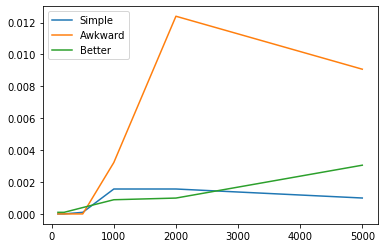

In [16]:
# Benchmarking

f = Solution()
lengths = [j*10**i for i in range(2,4) for j in [1,2,5]]
print(lengths)
methods = [simple, f.process, better]
methodNames = ['Simple','Awkward','Better']
n_tries = 10

history = np.zeros(shape=(len(lengths),len(methods)))
for ifun in range(len(methods)):
    fun = methods[ifun]
    for il in range(len(lengths)):
        for _ in range(n_tries):
            s = generate(lengths[il])
            tic = time.time()
            fun(s)
            history[il,ifun] += time.time()-tic
        print('.',end='')
history = history/n_tries
        
# plotting

for i in range(history.shape[1]):
    plt.plot(lengths,history[:,i]);
plt.legend(methodNames);

OK, nice, the supposdly "fancy" solution with trees is wa-ay slower than a simple solution, and with no sign of reversal at hith n. That's sad. Screw it then. Let's test the other two:

[100, 200, 500, 1000, 2000, 5000]
............

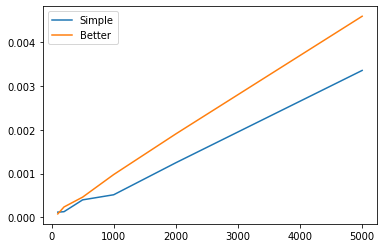

In [6]:
# Benchmarking, 2 solutions only

import time
import matplotlib.pyplot as plt

lengths = [j*10**i for i in range(2,4) for j in [1,2,5]]
print(lengths)
methods = [simple, better]
methodNames = ['Simple','Better']
n_tries = 100

history = np.zeros(shape=(len(lengths),len(methods)))
for ifun in range(len(methods)):
    fun = methods[ifun]
    for il in range(len(lengths)):
        for _ in range(n_tries):
            s = generate(lengths[il])
            tic = time.time()
            fun(s)
            history[il,ifun] += time.time()-tic
        print('.',end='')
history = history/n_tries
        
# plotting

for i in range(history.shape[1]):
    plt.plot(lengths,history[:,i]);
plt.legend(methodNames);

Huh, again, better solution is not necessarily better, even tho it's supposed to be O(N), while a simple one is O(N^2)... Either my code is super-inefficient, or my test cases are not good enough (too many shallow brackets)?

In [14]:
def generate2(n):
    """Generate the worst-case sequence."""
    s = 'z'
    for i in range(n):
        s = chr(ord('a')+(i % (ord('z')-ord('a')))) + '(' + s + ')'
    return s
        
# test
print(generate2(1))
print(generate2(3))
print(generate2(100))

a(z)
c(b(a(z)))
y(x(w(v(u(t(s(r(q(p(o(n(m(l(k(j(i(h(g(f(e(d(c(b(a(y(x(w(v(u(t(s(r(q(p(o(n(m(l(k(j(i(h(g(f(e(d(c(b(a(y(x(w(v(u(t(s(r(q(p(o(n(m(l(k(j(i(h(g(f(e(d(c(b(a(y(x(w(v(u(t(s(r(q(p(o(n(m(l(k(j(i(h(g(f(e(d(c(b(a(z))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))))


[100, 200, 500, 1000, 2000, 5000]
............

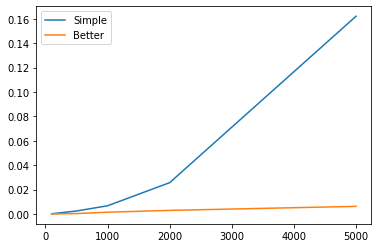

In [17]:
# Benchmarking, 2 solutions only

import time
import matplotlib.pyplot as plt

lengths = [j*10**i for i in range(2,4) for j in [1,2,5]]
print(lengths)
methods = [simple, better]
methodNames = ['Simple','Better']
n_tries = 10

history = np.zeros(shape=(len(lengths),len(methods)))
for ifun in range(len(methods)):
    fun = methods[ifun]
    for il in range(len(lengths)):
        for _ in range(n_tries):
            s = generate2(lengths[il])
            tic = time.time()
            fun(s)
            history[il,ifun] += time.time()-tic
        print('.',end='')
history = history/n_tries
        
# plotting

for i in range(history.shape[1]):
    plt.plot(lengths,history[:,i]);
plt.legend(methodNames);

OK, so indeed, a simple solution works better with shallow strings, but for deeper strings O(N) is better!